In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.manifold import TSNE
import numpy as np
import plotly.express as px

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Custom Dataset for VisualSpectrumDataset
class VisualSpectrumDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_paths = []
        self.labels = []  # Each label is a tuple: (category, subcategory)
        self.transform = transform
        
        # Assume folder structure: root/category/subcategory/image.jpg
        for category in os.listdir(root_dir):
            category_path = os.path.join(root_dir, category)
            if os.path.isdir(category_path):
                for subcategory in os.listdir(category_path):
                    subcategory_path = os.path.join(category_path, subcategory)
                    if os.path.isdir(subcategory_path):
                        for file in os.listdir(subcategory_path):
                            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                                self.image_paths.append(os.path.join(subcategory_path, file))
                                self.labels.append((category, subcategory))
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]

# Define image transforms
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

# Initialize the dataset and dataloader
dataset = VisualSpectrumDataset("VisualSpectrumDataset", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Define a simple convolutional autoencoder
class ConvAutoencoder(nn.Module):
    def __init__(self, latent_dim=128):
        super(ConvAutoencoder, self).__init__()
        # Encoder: Convolutional layers to compress the image
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 128x128 -> 64x64
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),   # 64x64 -> 32x32
            nn.ReLU(True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 32x32 -> 16x16
            nn.ReLU(True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), # 16x16 -> 8x8
            nn.ReLU(True),
            nn.Flatten(),
            nn.Linear(256*8*8, latent_dim)
        )
        # Decoder: Deconvolutional layers to reconstruct the image
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256*8*8),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 8x8 -> 16x16
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),   # 16x16 -> 32x32
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),    # 32x32 -> 64x64
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),     # 64x64 -> 128x128
            nn.Sigmoid()  # Scale output between 0 and 1
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        recon = self.decoder(latent)
        return recon
    
    def encode(self, x):
        return self.encoder(x)

# Initialize the autoencoder and move to device
model = ConvAutoencoder(latent_dim=128).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Train the autoencoder for a few epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for imgs, _ in dataloader:
        imgs = imgs.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, imgs)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
    epoch_loss = running_loss / len(dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# Extract features from the encoder (latent representations)
model.eval()
features = []
labels = []

with torch.no_grad():
    for imgs, labs in DataLoader(dataset, batch_size=32):
        imgs = imgs.to(device)
        latent = model.encode(imgs)
        features.append(latent.cpu().numpy())
        labels.extend(labs)
features = np.concatenate(features, axis=0)

# Apply t-SNE to reduce the 128-dimensional features to 2 dimensions
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(features)



Using device: cuda


C:\Users\soumy\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Epoch [1/10], Loss: 0.0703
Epoch [2/10], Loss: 0.0543
Epoch [3/10], Loss: 0.0472
Epoch [4/10], Loss: 0.0385
Epoch [5/10], Loss: 0.0349
Epoch [6/10], Loss: 0.0334
Epoch [7/10], Loss: 0.0324
Epoch [8/10], Loss: 0.0312
Epoch [9/10], Loss: 0.0289
Epoch [10/10], Loss: 0.0265


ValueError: All arguments should have the same length. The length of argument `color` is 64, whereas the length of  previously-processed arguments ['x', 'y'] is 1000

In [14]:
print (len(categories_list))

64


['Architecture', 'Historical', 'Architecture', 'Historical', 'Architecture', 'Industrial', 'Architecture', 'Industrial', 'Architecture', 'Modern', 'Architecture', 'Urban', 'Architecture', 'Urban', 'Art & Design', 'Abstract', 'Art & Design', 'Digital', 'Art & Design', 'Digital', 'Art & Design', 'Minimalist', 'Art & Design', 'Street Art', 'Art & Design', 'Street Art', 'Culture & Events', 'Festivals', 'Culture & Events', 'Festivals', 'Culture & Events', 'Landmarks', 'Culture & Events', 'Retro', 'Culture & Events', 'Retro', 'Culture & Events', 'Vintage', 'Nature', 'Deserts', 'Nature', 'Deserts', 'Nature', 'Forests', 'Nature', 'Ice Formations', 'Nature', 'Ice Formations', 'Nature', 'Mountains', 'Science & Space', 'Astronomy', 'Science & Space', 'Astronomy', 'Science & Space', 'Futuristic', 'Science & Space', 'Futuristic', 'Science & Space', 'Microscopic', 'Science & Space', 'Surreal', 'Science & Space', 'Surreal']


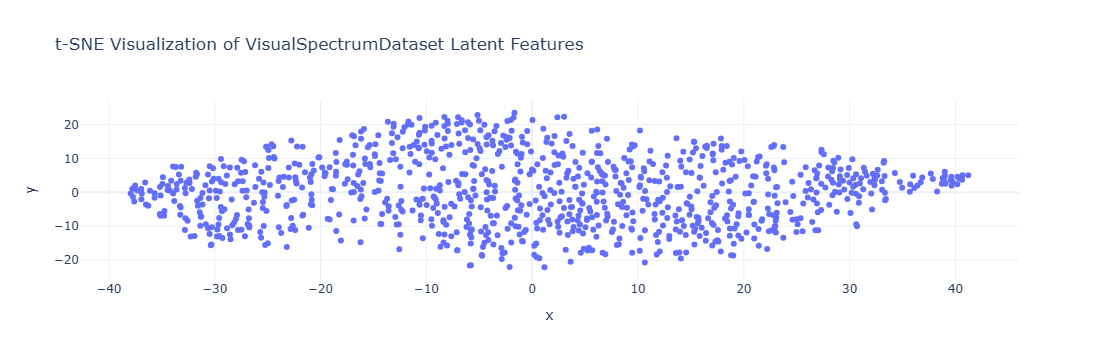

In [20]:
# Prepare data for Plotly visualization
# I'll use the top-level category as the color label.
categories_list = [lab[1] for lab in labels]
print (categories_list)
# Create a Plotly scatter plot
fig = px.scatter(
    x=tsne_results[:, 0],
    y=tsne_results[:, 1],
    title="t-SNE Visualization of VisualSpectrumDataset Latent Features",
    template="plotly_white"
)

fig.show()
